# Hometask 5

1. Попробуйте изменить параметры нейронной сети работающей с датасетом imdb либо нейронной сети работающей airline-passengers (она прилагается вместе с датасетом к уроку в виде отдельного скрипта) так, чтобы улучшить ее точность. Приложите анализ.
1. Попробуйте изменить параметры нейронной сети генерирующий текст таким образом, чтобы добиться генерации как можно более осмысленного текста. Пришлите лучший получившейся у вас текст и опишите, что вы предприняли, чтобы его получить. Можно использовать текст другого прозведения.

In [57]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pandas as pd

In [30]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/learn/05n

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/learn/05n


In [101]:
numpy.random.seed(7)

dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

92/92 - 3s - loss: 0.0053 - mean_absolute_error: 0.0553 - 3s/epoch - 30ms/step
92/92 - 0s - loss: 0.0149 - mean_absolute_error: 0.0947 - 388ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0086 - mean_absolute_error: 0.0748 - 370ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0062 - mean_absolute_error: 0.0634 - 339ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0053 - mean_absolute_error: 0.0578 - 251ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0049 - mean_absolute_error: 0.0553 - 266ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0048 - mean_absolute_error: 0.0543 - 262ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0048 - mean_absolute_error: 0.0537 - 261ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0047 - mean_absolute_error: 0.0533 - 272ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0047 - mean_absolute_error: 0.0530 - 256ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0047 - mean_absolute_error: 0.0527 - 263ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0046 - mean_absolute_error: 0.0525 - 268ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0046 - me

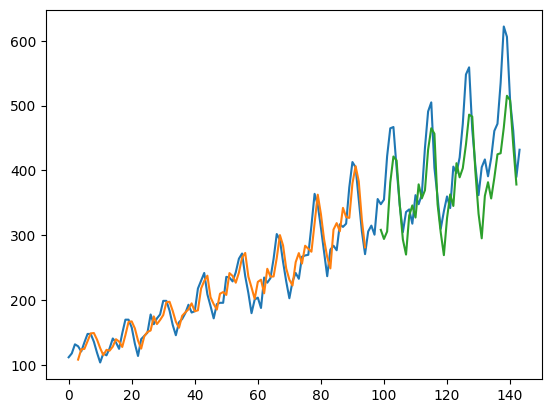

In [102]:
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
for i in range(100):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()

trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

trainScore = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score: %.3f MAE' % (trainScore))
testScore = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.3f MAE' % (testScore))

trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show() 

## Решение 1

Сделаем несколько функций, чтобы удобней было использовать.

In [70]:
def calc_results(model, batch_size=1, func_error=mean_squared_error, print_results=False):
    trainPredict = model.predict(trainX, batch_size=batch_size)
    model.reset_states()
    testPredict = model.predict(testX, batch_size=batch_size)

    trainPredict = scaler.inverse_transform(trainPredict)
    train_Y = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    test_Y = scaler.inverse_transform([testY])

    trainScore = math.sqrt(mean_squared_error(train_Y[0], trainPredict[:,0]))
    if print_results:
        print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(test_Y[0], testPredict[:,0]))
    if print_results:
        print('Test Score: %.2f RMSE' % (testScore))

    return trainPredict, testPredict, trainScore, testScore

def show_results(trainPredict, testPredict):
    trainPredictPlot = numpy.empty_like(dataset)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    testPredictPlot = numpy.empty_like(dataset)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

In [105]:
numpy.random.seed(7)

dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [72]:
trainX.shape, trainY.shape

((92, 3, 1), (92,))

Попробуем поменять batch.

In [75]:
batch_sizes = [1, 2] 
results = list()

for bs in batch_sizes:
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(bs, look_back, 1), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    for i in range(100):
        model.fit(trainX, trainY, epochs=1, batch_size=bs, verbose=0, shuffle=False)
        model.reset_states()
    trainPredist, testPredict, trainScore, testScore = calc_results(model, batch_size=bs)
    score, acc = model.evaluate(testX, testY, batch_size=bs)
    results.append({'trainPredist':trainPredist, 'testPredict':testPredict,
                    'trainScore': trainScore, 'testScore': testScore,
                    'batch_size':bs, 'score':score, 'acc': acc})
    
data_res = pd.DataFrame(results).sort_values('testScore')
data_res

22/22 [==============================] - 0s 3ms/step - loss: 0.0144 - accuracy: 0.0227


,trainPredist,testPredict,trainScore,testScore,batch_size,score,acc
1,"[[106.56424], [108.70041], [115.425835], [118....","[[220.82556], [225.32602], [280.97], [305.0504...",28.355614,74.581141,2,0.014353,0.022727
0,"[[146.60425], [137.22084], [123.60309], [131.6...","[[355.8503], [319.36862], [319.2792], [388.794...",25.904494,78.484171,1,0.024850,0.022727


In [62]:
batch_size = data_res.reset_index()['batch_size'][0]
batch_size

2

На первый взгляд разница о mse не сильная (можно сказать в пределах погрешности). A accuracy вообще не различается. Поэтому используем mse. Что насчитали, то и используем.

Попробуем подобрать loss.

In [76]:
trainX.shape, trainY.shape

((92, 3, 1), (92,))

Метрика accuracy совсем не катит. Надо поменять на mae.

In [91]:
losss = ['mean_squared_error',
         'mean_absolute_error',
         'mean_absolute_percentage_error',
         'binary_crossentropy',
         'poisson',
         'mean_squared_logarithmic_error',
         'cosine_similarity']
results = list()

for ls in losss:
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
    model.add(Dense(1))
    model.compile(loss=ls, optimizer='adam', metrics=['mean_absolute_error'])
    for i in range(100):
        model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    # trainPredist, testPredict, trainScore, testScore = calc_results(model, batch_size=batch_size)
    score, m_a_e = model.evaluate(testX, testY, batch_size=batch_size)
    results.append({'func_loss':ls, 'score':score, 'mae': m_a_e})
    
data_res = pd.DataFrame(results).sort_values('mae').reset_index()
data_res

22/22 [==============================] - 0s 3ms/step - loss: -1.0000 - mean_absolute_error: 0.2437


,index,func_loss,score,mae
0,3,binary_crossentropy,0.648825,0.089366
1,1,mean_absolute_error,0.121997,0.121997
2,0,mean_squared_error,0.027477,0.126327
3,6,cosine_similarity,-1.000000,0.243690
4,5,mean_squared_logarithmic_error,0.230084,0.655236
5,2,mean_absolute_percentage_error,108.163376,0.655644
6,4,poisson,NaN,25.674440


Меняем функцию потерь.



In [92]:
loss_function = data_res['func_loss'][0]
loss_function

'binary_crossentropy'

Усложним сеть и посмотрим есть ли шанс на этом шаге улучшить метрику.

In [95]:
results = list()

model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(8))
model.add(Dense(1))
model.compile(loss=loss_function, optimizer='adam', metrics=['mean_absolute_error'])
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
# trainPredist, testPredict, trainScore, testScore = calc_results(model, batch_size=batch_size)
score, m_a_e = model.evaluate(testX, testY, batch_size=batch_size)
# results.append({'trainPredist':trainPredist, 'testPredict':testPredict,
#                 'trainScore': trainScore, 'testScore': testScore,
#                 'score':score, 'acc': acc})
  
# data_res = pd.DataFrame(results).sort_values('testScore')
# data_res
score, m_a_e

22/22 [==============================] - 1s 3ms/step - loss: 0.6943 - mean_absolute_error: 0.1393


(0.6942771673202515, 0.13929809629917145)

Несколько запусков показывают, что баш на баш. Лучше использовать первый вариант.

Ещё сделаем подбор оптимизатора.

In [96]:
optimizers = ['Adam',
         'RMSprop',
         'Adamax',
         'Nadam']
results = list()

for op in optimizers:
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
    model.add(Dense(1))
    model.compile(loss=loss_function, optimizer=op, metrics=['mean_absolute_error'])
    for i in range(100):
        model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    # trainPredist, testPredict, trainScore, testScore = calc_results(model, batch_size=batch_size)
    score, m_a_e = model.evaluate(testX, testY, batch_size=batch_size)
    results.append({'optimizer':op, 'score':score, 'mae': m_a_e})
    
data_res = pd.DataFrame(results).sort_values('mae').reset_index()
data_res

22/22 [==============================] - 1s 3ms/step - loss: 0.6461 - mean_absolute_error: 0.0880


,index,optimizer,score,mae
0,3,Nadam,0.646090,0.087981
1,1,RMSprop,0.650586,0.098464
2,0,Adam,0.656693,0.105393
3,2,Adamax,0.672350,0.124627


In [97]:
optimizer = data_res['optimizer'][0]
optimizer

'Nadam'

In [107]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss=loss_function, optimizer=op, metrics=['mean_absolute_error'])
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
# trainPredist, testPredict, trainScore, testScore = calc_results(model, batch_size=batch_size)
score, m_a_e = model.evaluate(testX, testY, batch_size=batch_size)
score, m_a_e

22/22 [==============================] - 0s 3ms/step - loss: 0.6467 - mean_absolute_error: 0.0863


(0.64666748046875, 0.08633500337600708)

Тестовый/исходный вариант пришлось пересчитать, чтобы везде была одна метрика. МАЕ на исходном варианте 0,46. На последнем 0,086. Результат на лицо. Но факт случайности то же не отменяется.

Для достижения результатов были изменены/подобраны:

- batch_size
- loss
- optimizer

## Решение 2

Попробуйте изменить параметры нейронной сети генерирующий текст таким образом, чтобы добиться генерации как можно более осмысленного текста. Пришлите лучший получившейся у вас текст и опишите, что вы предприняли, чтобы его получить. Можно использовать текст другого прозведения.

In [1]:
import numpy as np
from keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/learn/05n

Mounted at /content/gdrive
/content/gdrive/MyDrive/learn/05n


In [3]:
with open("alice_in_wonderland.txt", 'rb') as _in:
    lines = []
    for line in _in:
        line = line.strip().lower().decode("utf-8", "ignore")
        if len(line) == 0:
            continue
        lines.append(line)
text = " ".join(lines)
chars = set([c for c in text])
nb_chars = len(chars)

In [ ]:
# создание индекса символов и reverse mapping чтобы передвигаться между значениями numerical
# ID and a specific character. The numerical ID will correspond to a column
# ID и определенный символ. Numerical ID будет соответсвовать колонке
# число при использовании one-hot кодировки для представление входов символов
char2index = {c: i for i, c in enumerate(chars)}
index2char = {i: c for i, c in enumerate(chars)}

# для удобства выберете фиксированную длину последовательность 10 символов 
SEQLEN, STEP = 120, 2
input_chars, label_chars = [], []

# конвертация data в серии разных SEQLEN-length субпоследовательностей
for i in range(0, len(text) - SEQLEN, STEP):
    input_chars.append(text[i: i + SEQLEN])
    label_chars.append(text[i + SEQLEN])


# Вычисление one-hot encoding входных последовательностей X и следующего символа (the label) y

X = np.zeros((len(input_chars), SEQLEN, nb_chars), dtype=np.bool)
y = np.zeros((len(input_chars), nb_chars), dtype=np.bool)
for i, input_char in enumerate(input_chars):
    for j, ch in enumerate(input_char):
        X[i, j, char2index[ch]] = 1
    y[i, char2index[label_chars[i]]] = 1


# установка ряда метапамертров  для нейронной сети и процесса тренировки
BATCH_SIZE, HIDDEN_SIZE = 64, 256
NUM_ITERATIONS = 25
NUM_EPOCHS_PER_ITERATION = 20
NUM_PREDS_PER_EPOCH = 100


# Create a super simple recurrent neural network. There is one recurrent
# layer that produces an embedding of size HIDDEN_SIZE from the one-hot
# encoded input layer. This is followed by a Dense fully-connected layer
# across the set of possible next characters, which is converted to a
# probability score via a standard softmax activation with a multi-class
# cross-entropy loss function linking the prediction to the one-hot
# encoding character label.

'''
Создание очень простой рекуррентной нейронной сети. В ней будет один реккурентный 
закодированный входной слой. За ним последует полносвязный слой связанный с набором возможных 
следующих символов, которые конвертированы в вероятностные результаты через стандартную softmax активацию 
с multi-class cross-encoding loss функцию ссылающуются на предсказание one-hot encoding лейбл символа
'''

model = Sequential()
model.add(
    GRU(  # вы можете изменить эту часть на LSTM или SimpleRNN, чтобы попробовать альтернативы
        HIDDEN_SIZE,
        return_sequences=False,
        input_shape=(SEQLEN, nb_chars),
        unroll=True
    )
)
model.add(Dense(nb_chars))
model.add(Activation("softmax"))
model.compile(loss="categorical_crossentropy", optimizer="rmsprop")


# выполнение серий тренировочных и демонстрационных итераций 
for iteration in range(NUM_ITERATIONS):

    # для каждой итерации запуск передачи данных в модель 
    print("=" * 50)
    print("Итерация #: %d" % (iteration))
    model.fit(X, y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS_PER_ITERATION)

    # Select a random example input sequence.
    test_idx = np.random.randint(len(input_chars))
    test_chars = input_chars[test_idx]

    # для числа шагов предсказаний использование текущей тренируемой модели 
    # конструирование one-hot encoding для тестирования input и добавление предсказания.
    print("Генерация из посева: %s" % (test_chars))
    print(test_chars, end="")
    for i in range(NUM_PREDS_PER_EPOCH):

        # здесь one-hot encoding.
        X_test = np.zeros((1, SEQLEN, nb_chars))
        for j, ch in enumerate(test_chars):
            X_test[0, j, char2index[ch]] = 1

        # осуществление предсказания с помощью текущей модели.
        pred = model.predict(X_test, verbose=0)[0]
        y_pred = index2char[np.argmax(pred)]

        # вывод предсказания добавленного к тестовому примеру 
        print(y_pred, end="")

        # инкрементация тестового примера содержащего предсказание
        test_chars = test_chars[1:] + y_pred
print()

<ipython-input-4-b5c5e2be4988>:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.zeros((len(input_chars), SEQLEN, nb_chars), dtype=np.bool)
<ipython-input-4-b5c5e2be4988>:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(input_chars), nb_chars), dtype=np.bool)


Итерация #: 0
Epoch 1/20
1264/1264 [==============================] - 129s 73ms/step - loss: 2.3588
Epoch 2/20
1264/1264 [==============================] - 105s 83ms/step - loss: 1.9787
Epoch 3/20
1264/1264 [==============================] - 95s 75ms/step - loss: 1.8007
Epoch 4/20
1264/1264 [==============================] - 109s 86ms/step - loss: 1.6628
Epoch 5/20
1264/1264 [==============================] - 112s 88ms/step - loss: 1.5511
Epoch 6/20
1264/1264 [==============================] - 110s 87ms/step - loss: 1.4547
Epoch 7/20
1264/1264 [==============================] - 90s 71ms/step - loss: 1.3690
Epoch 8/20
1264/1264 [==============================] - 87s 69ms/step - loss: 1.2901
Epoch 9/20
1264/1264 [==============================] - 107s 85ms/step - loss: 1.2165
Epoch 10/20
1264/1264 [==============================] - 87s 69ms/step - loss: 1.1444
Epoch 11/20
1264/1264 [==============================] - 86s 68ms/step - loss: 1.0763
Epoch 12/20
1264/1264 [====================

Обучение проводилось в colab, но и там это занимает прилично времени. Поэтому новых экспериментов не будет, а будет только текст.

Для более осмысленного текста надо поработать с самим текстом до начала работы. Убрать падежи, склонения, окончания, суфиксы, привести к исходному слову (на сколько это возможно) в русском языке. И не забыть про ошибки и опечатки (если это пользовтаельский текст). Если английский (и подобные), то убрать слова которые не несут смысловой нагрузки (the, a, to... Для это можно попробовать pymorphy2. В конце также нужен механизм возврата к нормальному тексту. Если это касается англиского языка, то там нет таких сложностей, как в русском языке. Если русский, то надо учитывать особенности строения языка.

Текущий вариант сети более удачно начнёт формулировать смысловые варианты, т.к. не будет вариаций одного и того же слова в разных формах.

Хорошим вариантом будет добавить 1-2 слоя. Увеличить батч.

Если говорить про параметры, то для слоев LSTM и GRU в Keras можно использовать метрику accuracy, функцию потерь categorical_crossentropy и оптимизатор Adam (как пример). Однако, выбор метрики, функции потерь и оптимизатора зависит от конкретной задачи и данных, поэтому может потребоваться провести эксперименты с разными параметрами для получения наилучших результатов. А в данном случае это получается долго. Так что для домашней работы будет в этот раз пропущено.